'sed' (Spectral Energy Distribution) Dataset
===================================

Setup
--------

As a preparatory task, we create a file `Sed.dat`, containing common spectroscopic data. Apart from times, we also need wavelengths. For simplicity, the "observed" flux was set to 0.0. Of course, in real life this value is observed (in W m^-2 m^-1 units).

In [1]:
f = open("Sed.dat", "w")
f.write("# time wavelength flux sigma\n")

t = 0.0             # d
wave1 = 6500.0e-10  # m
wave2 = 6600.0e-10  # m
dwave = 0.1e-10     # m
flux = 0.0          # W m^-2 m^-1, at Earth
sigma = 1.0e-8      # ditto
    
wave = wave1
while wave < wave2+0.5*dwave:
    f.write("%.8f  %.8e  %.8f  %.8f\n" % (t, wave, flux, sigma))
    wave += dwave
    
f.close()

Modelling of SED requires a grid of <i>absolute</i> synthetic spectra (usually, >>10 GB). Here, a tiny 'test' grid will be used, so that this tutorial works without any installation; it is set up by the <tt>gridlist_ABS</tt> file, located in the current directory. Each file contains a single spectrum (wavelength in A, monochromatic flux in erg s^-1 cm^-2 A^-1, at stellar surface).

```
# filename Teff logg Z mu
grids_ABS/TEST/lte05900-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat  5900 4.00 1.0 1.0
grids_ABS/TEST/lte05900-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat  5900 4.50 1.0 1.0
grids_ABS/TEST/lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat  6000 4.00 1.0 1.0
grids_ABS/TEST/lte06000-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat  6000 4.50 1.0 1.0
grids_ABS/TEST/lte06100-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat  6100 4.00 1.0 1.0
grids_ABS/TEST/lte06100-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat  6100 4.50 1.0 1.0
```

Note: Make sure to have the latest version of PHOEBE 2.5 installed (uncomment this line if running in an online notebook session such as colab).

In [2]:
#!pip install -I "phoebe>=2.5,<2.6"

As always, let's do imports and add a new Bundle.

In [3]:
import phoebe

b = phoebe.default_binary()

Parameters
----------------

Next read `Sed.dat` back and add the corresponding 'sed' dataset:

In [4]:
import numpy as np

times, wavelengths, fluxes, sigmas = np.loadtxt("Sed.dat", usecols=[0, 1, 2, 3], unpack=True)

b.add_dataset('sed', times=times, wavelengths=wavelengths, fluxes=fluxes, sigmas=sigmas)

<ParameterSet: 44 parameters | contexts: compute, dataset, figure>

To verify:

In [5]:
print(b.get_dataset(kind='sed'))

ParameterSet: 10 parameters
              times@sed01@dataset: [0. 0. 0. ... 0. 0. 0.] d
        wavelengths@sed01@dataset: [6.5000e-07 6.5001e-07 6.5002e-07 ...
 6.5998e-07 6.5999e-07 6.6000e-07] m
             fluxes@sed01@dataset: [0. 0. 0. ... 0. 0. 0.] W / m3
      compute_times@sed01@dataset: [] d
             sigmas@sed01@dataset: [1.e-08 1.e-08 1.e-08 ... 1.e-08 1.e-08 1.e-08] W / m3
         sed_method@sed01@dataset: integrate
           passband@sed01@dataset: Johnson:V
   intens_weighting@sed01@dataset: energy
    ld_mode@primary@sed01@dataset: interp
   ld_mode@secondary@sed01@dat...: interp


### times
To see explanations:

In [6]:
print(b.get_parameter(kind='sed', qualifier='times', context='dataset'))

Parameter: times@sed01@dataset
                       Qualifier: times
                     Description: Observed times
                           Value: [0. 0. 0. ... 0. 0. 0.] d
                  Constrained by: 
                      Constrains: None
                      Related to: None



### wavelengths
Alternatively, one can use the `twig` syntax.

In [7]:
print(b['wavelengths@sed01@sed@dataset'])

Parameter: wavelengths@sed01@dataset
                       Qualifier: wavelengths
                     Description: Observed wavelengths
                           Value: [6.5000e-07 6.5001e-07 6.5002e-07 ... 6.5998e-07 6.5999e-07
 6.6000e-07] m
                  Constrained by: 
                      Constrains: None
                      Related to: None



### fluxes

In [8]:
print(b['fluxes@sed01@sed@dataset'])

Parameter: fluxes@sed01@dataset
                       Qualifier: fluxes
                     Description: Observed fluxes
                           Value: [0. 0. 0. ... 0. 0. 0.] W / m3
                  Constrained by: 
                      Constrains: None
                      Related to: None



### sigmas

In [9]:
print(b['sigmas@sed01@sed@dataset'])

Parameter: sigmas@sed01@dataset
                       Qualifier: sigmas
                     Description: Observed uncertainty of flux
                           Value: [1.e-08 1.e-08 1.e-08 ... 1.e-08 1.e-08 1.e-08] W / m3
                  Constrained by: 
                      Constrains: None
                      Related to: None



### sed_method
One can choose either a simple model, assuming a uniform disk(s), or a complex model, with integration over meshes --- i.e., applicable to contact or eclipsing binaries.

In [10]:
print(b.get_parameter(qualifier='sed_method', context='dataset'))

Parameter: sed_method@sed01@dataset
                       Qualifier: sed_method
                     Description: Method to use for computing synthetic spectra (must be integrate for eclipse effects)
                           Value: integrate
                         Choices: integrate, simple
                  Constrained by: 
                      Constrains: None
                      Related to: None



Of course, one has to set up the distance, because the absolute flux is measured at Earth!

In [11]:
from astropy import units

b.set_value('distance', context='system', value=1*units.au)

Model
---------

Before we proceed, let's increase the resolution of meshes, to suppress artefacts on line profiles:

In [12]:
b.set_value('ntriangles@primary', context='compute', value=2000)
b.set_value('ntriangles@secondary', context='compute', value=2000)

Since we use our own absolute spectra (i.e., not the atmospheres included in Phoebe), we have to account for the limb darkening by choosing an analytical limb-darkening law: 

In [13]:
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_func', 'linear')
b.set_value_all('ld_coeffs', [0.3])

Eventually, a computation is run as:

In [14]:
b.run_compute()

  0%|          | 0/1 [00:00<?, ?it/s]

Loading file: grids_ABS/TEST/lte05900-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat
Loading file: grids_ABS/TEST/lte05900-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat
Loading file: grids_ABS/TEST/lte05900-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat
Loading file: grids_ABS/TEST/lte06000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat
Loading file: grids_ABS/TEST/lte06000-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat
Loading file: grids_ABS/TEST/lte06100-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat
Loading file: grids_ABS/TEST/lte06100-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.vis.dat


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


<ParameterSet: 5 parameters | qualifiers: times, wavelengths, fluxes, comments, sed_method>

Now, I know that I can print, e.g.:

In [15]:
print(b.get_model(kind='sed'))

ParameterSet: 4 parameters
R              times@latest@model: [0. 0. 0. ... 0. 0. 0.] d
R        wavelengths@latest@model: [6.5000e-07 6.5001e-07 6.5002e-07 ... 6.5998e-07
 6.5999e-07 6.6000e-07] m
R             fluxes@latest@model: [1.54098175e+09 1.55175630e+09 1.55722616e+09 ...
 1.58258051e+09 1.58350739e+09 1.58427975e+09] W / m3
          sed_method@latest@model: integrate


To save results:

In [16]:
times = b['times@sed01@phoebe01@latest@sed@model'].value
wavelengths = b['wavelengths@sed01@phoebe01@latest@sed@model'].value
fluxes = b['fluxes@sed01@phoebe01@latest@sed@model'].value

np.savetxt('model.out', np.c_[times, wavelengths, fluxes], header='times wavelenghts fluxes')

Plotting
-----------

To plot results:

/home/mira/.local/lib/python3.9/site-packages/phoebe/dependencies/autofig/axes.py:1273: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(xlim)


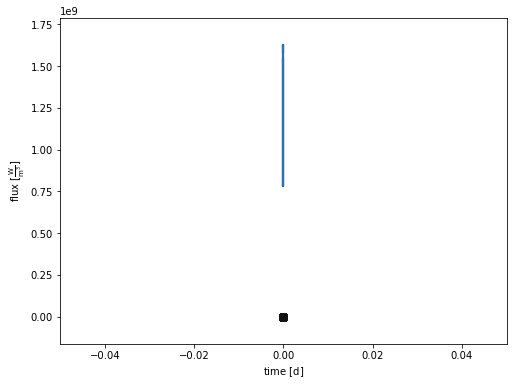

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [17]:
b.plot(show=True)

Well, this was for a single time, wasn't it? It is much more interesting to see the dependence on wavelengths!

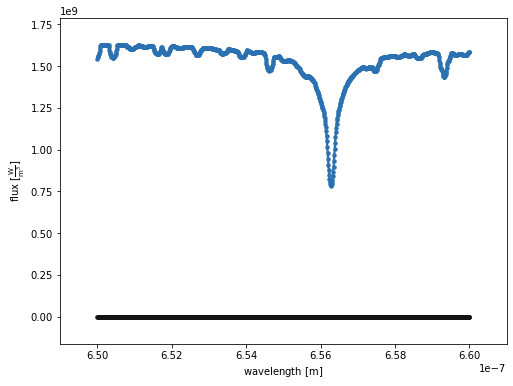

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [18]:
b.plot(x='wavelengths', marker='.', linestyle='-', show=True)

Since the phase is 0.0, one of the stars is eclipsed. Consequently, the monochromatic flux F_nu corresponds approximately to the solar value, i.e., 2 x 10^9 W m^-2 m^-1. Of course, if the time is modified (0.25), it should be twice as much...

Note: A 'miniaturized' version of Pyterpol3 (Nemravová et al. 2016, A&A 594, A55) is used internally to interpolate synthetic spectra. Supported grids include: OSTAR, BSTAR, POLLUX, or PHOENIX. They must be downloaded (http://sirrah.troja.mff.cuni.cz/~mira/xitau/) and present in the `grids_ABS` directory.